# Introduction

In this article, we show how to represent basic poker elements in Python, e.g., Hands and Combos, and how to calculate poker odds, i.e., likelihood of win/tie/lose in No-Limit Texas Hold'em.

We provide a practical analysis based on a real story in a *Night at the Venetian*.

We will use the package **poker** to represent hands, combos and ranges. I have extended the poker odds calculator from [Kevin Tseng](https://github.com/ktseng/holdem_calc), so it is able to calculate poker probabilities based on ranges (set of possible hands) in addition to individual hands. The final code is available in my [repo](https://github.com/souzatharsis/holdem_calc).

In [1]:
from poker import Range
from poker.hand import Combo

import holdem_calc
import holdem_functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

hero_odds = []
hero_range_odds = []

# The Flop

I was dealt with King of Spades and Jack of Clubs (K♠J♣). I will use the Class Combo from the **poker.hand** package to construct my hand.

In [2]:
# my hand = King of spades and Jack of clubs
hero_hand = Combo('KsJc')
print(hero_hand)

K♠J♣


I do not remember exactly what happened pre-flop and what my position was. However, I do remember there was a raise pre-flop and only two players were left post-flop: myself and the villain.

We are now heads-up. The flop comes Queen of Clubs, Ten of Hearts and Jack of Clubs. Yes, I flopped a Straight!

Let's calculate my odds post-flop assuming no prior knowledge about the villain's cards, i.e., we will compute how likely my hand is to win against a random pair of hole cards given the flop.

In [3]:
flop = ["Qc", "Th", "9s"] # the flop
board = flop # the board equals the flop
villan_hand = None # no prior knowledge about the villan
exact_calculation = True #  calculates exactly by simulating the set of all possible hands
verbose = True # returns odds of making a certain poker hand, e.g., quads, set, straight
num_sims = 1 # ignored by exact_calculation = True
read_from_file = None # we are not reading hands from file


odds = holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = True)

Time elapsed:  11.021019220352173


The function **calculate_odds_villan** from **holdem_calc** calculates the probability that a certain Texas Hold'em hand will win. This probability is approximated by running a Monte Carlo method or calculated exactly by simulating the set of all possible hands. Calculating exact odds post-flop is fast so we won't need Monte Carlo approximations here. Here's our odds:

In [4]:
hero_odds.append(odds[0]['win'])

In [5]:
odds[0]

{'tie': 0.04138424018164999,
 'win': 0.9308440557284221,
 'lose': 0.027771704089927955}

At this point I'm feeling pretty good. Against a random hand, I only have a 2.77% chance to lose and over 93% chance to win. However, that's optimistic.

Given that there was a raise pre-flop and only myself and the villain were left post-flop, it's likely the villain has something, right? We call this likely set of hands a *range*. This is an inference we make based on several factors including villain's behavior, position, bet size etc. This inference leads to a set of combos of hands we assume the villain might have. At this point, I was thinking the villain had: 
   * A pair of sevens or better
   * Ace / Ten or better
   * King / Jack or better
We can represent this range using the Class Range as below:

In [6]:
villan_range = Range('77+, AT+, KJ+')
display(HTML(villan_range.to_html()))
print("#combo combinations:" + str(len(villan_range.combos)))

AA,AKs,AQs,AJs,ATs,,,,,,,,
AKo,KK,KQs,KJs,,,,,,,,,
AQo,KQo,QQ,,,,,,,,,,
AJo,KJo,,JJ,,,,,,,,,
ATo,,,,TT,,,,,,,,
,,,,,99,,,,,,,
,,,,,,88,,,,,,
,,,,,,,77,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,


#combo combinations:144


This brings our villain's hand combos down to 144 combinations from a total of 51*52–1 = 2651 possible hands. Let's calculate my odds now assuming ranges for the villain.

In [7]:
items = [holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = False) for villan_hand in villan_range.combos]

odds = {}
[odds.update({odd_type: np.mean([res[0][odd_type] for res in items if res])}) for odd_type in ["tie", "win", "lose"]]

[None, None, None]

In [8]:
hero_range_odds.append(odds['win'])

In [9]:
odds

{'tie': 0.11423324150596878,
 'win': 0.8030711151923272,
 'lose': 0.08269564330170392}

Given the assumed ranges, my winning odds dropped from a 93% to 80%. However, I still have a very low probability of losing of 8.2%. At this point, I'm pretty comfortable. But should I bet? I definitively want the villain to continue playing and not fold yet. But how likely is he of having a good hand post-flop? Let's see what are the odds of him making a hand if we continued playing until the end.

In [10]:
for hand_ranking in holdem_functions.hand_rankings:
    print(hand_ranking +": " + str(np.mean([res[1][1][hand_ranking] for res in items if res])))

High Card: 0.06978879706152433
Pair: 0.3662891541679421
Two Pair: 0.23085399449035812
Three of a Kind: 0.09733700642791548
Straight: 0.18498112437506373
Flush: 0.0040608101214161816
Full House: 0.04205693296602388
Four of a Kind: 0.004560759106213652
Straight Flush: 2.0406081012141617e-05
Royal Flush: 5.101520253035404e-05


If we continue playing until the river, the villain has a good chance of making a Pair (36%) or even Two Pair (23%). He has a nice probability of hitting a Straight (18%) or even making a Set (9.7%) or a Full House (4%). As the villain has a good chance of having a reasonable hand, I then decide to bet high, about 2/3 of the pot. The villain tanks and finally calls.

# The Turn

The turn comes and it's a duece of diamonds (2♦). Basically, it's a blank, i.e., it does not change much our game.

In [11]:
turn= ["2d"]
board = flop + turn
villan_hand = None

odds = holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = True)
hero_odds.append(odds[0]['win'])

print(odds[0])

Time elapsed:  0.5410661697387695
{'tie': 0.0233201581027668, 'win': 0.9677206851119895, 'lose': 0.008959156785243741}


Assuming random cards for the villain, I am now with 96% odds of winning. However, considering my assumed ranges for the villain, my winning odds are now 86% up from 80% in the flop. I bet high again, the villain calls and here comes the river.

In [12]:
items = [holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = False) for villan_hand in villan_range.combos]

odds = {}
[odds.update({odd_type: np.mean([res[0][odd_type] for res in items if res])}) for odd_type in ["tie", "win", "lose"]]

[None, None, None]

In [13]:
hero_range_odds.append(odds['win'])

In [14]:
odds

{'tie': 0.10123966942148759,
 'win': 0.8615702479338843,
 'lose': 0.0371900826446281}

# The River

King of Clubs is the river (K♣). A King in the river makes a Straight much more likely for the villain to hold. So this is bad news for me.

In [15]:
river = ["Kc"]
board = flop + turn + river 
verbose = True

villan_hand = None

odds = holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = True)
hero_odds.append(odds[0]['win'])

print(odds[0])

Time elapsed:  0.03231000900268555
{'tie': 0.11818181818181818, 'win': 0.8696969696969697, 'lose': 0.012121212121212121}


Now, my winning odds dropped from 96% to about 87% against random cards. But I'm still losing only with a very low probability of 1.2%. OK, the bad river is not that bad, right?

Well, there is one additional factor. The villain called my big bets both in the flop and in the river. He might have something better than I thought… right? I should then adjust my assumed ranges.

Now, I'm thinking the villain no longer has 77's or 88's combos, otherwise he would not go that far given my high bets. I am thinking he might have a pair of 99's or better to make sets with 99's, 10's or QQ's. He might also have JJ's for a mid-pair and straight-draw. Or KK's and AA's which would be top pairs until the turn. I decided to keep the Ace Ten or better and the King Jack or better combos because of something called *implied odds*. Implied odds is an estimation on how much money you can win from the bet if you hit one of your outs. So the villain might be sticky waiting to hit a draw (which he might have just hit now??). Hence, I define my villain's updated range as follows:

In [16]:
villan_range = Range('99+, AT+, KJ+') 
display(HTML(villan_range.to_html()))
print("#combo combinations:" + str(len(villan_range.combos)))

AA,AKs,AQs,AJs,ATs,,,,,,,,
AKo,KK,KQs,KJs,,,,,,,,,
AQo,KQo,QQ,,,,,,,,,,
AJo,KJo,,JJ,,,,,,,,,
ATo,,,,TT,,,,,,,,
,,,,,99,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,


#combo combinations:132


Now the villain's combos are 132 down from 144. Let's calculate the updated odds.

In [17]:
items = [holdem_calc.calculate_odds_villan(board, exact_calculation, 
                            num_sims, read_from_file , 
                            hero_hand, villan_hand, 
                            verbose, print_elapsed_time = False) for villan_hand in villan_range.combos]

odds = {}
[odds.update({odd_type: np.mean([res[0][odd_type] for res in items if res])}) for odd_type in ["tie", "win", "lose"]]

[None, None, None]

In [18]:
hero_range_odds.append(odds['win'])

In [19]:
odds

{'tie': 0.12, 'win': 0.72, 'lose': 0.16}

I now have a 72% chance to win (down from 86%) and my chances or losing have increased from 3.7% to 16% compared to our range analysis during the turn. I decide to check and the villain goes all-in, betting roughly 70% of the pot.

A basic and standard river strategy tells you the following:
1. Use your absolute weakest holdings as river bluffs
2. Use your strongest holdings as value-bets
3. Check hands with mid-strength showdown-value in the hope of reaching showdown

In [20]:
for hand_ranking in holdem_functions.hand_rankings:
    print(hand_ranking +": " + str(np.mean([res[1][1][hand_ranking] for res in items if res])))

High Card: 0.0
Pair: 0.5066666666666667
Two Pair: 0.08
Three of a Kind: 0.13333333333333333
Straight: 0.28
Flush: 0.0
Full House: 0.0
Four of a Kind: 0.0
Straight Flush: 0.0
Royal Flush: 0.0


From the odds histogram, we can group the villain's possible hands in 3 types:
1. Bluff: He is holding {High Card, Pair} with 60.66% chance
2. Mid-strength hand: He is holding {Two Pair} with 0.8% chance
3. Value-bet (strongest holdings): He is holding {Three of a Kind, Straight} with 41.33% chance

The villain's all-in makes sense, his mid-strength hand probability is too low to check. So here I'm thinking he is either bluffing, for instance due to a missed draw, or he has the nuts, and this is a value bet. This basic strategy of either bluffing if you have your weakest holdings or value-betting if you have a strong holding is sometimes called a polarized bet. That's what the villain is doing here.

Looking back at the probabilities per type (bluff, mid-strength hand, value-bet), I basically should win at least 60.66% of the time and this is a conservative measure as the villain might be value betting a three of a kind. But should I call?

Here comes another concept called *pot odds*. Pot odds refers to the price of calling a bet relative to the size of the pot. In summary, I should call if my probability of winning the pot is higher than the ratio between the price to call and the size of the pot after my call. Let's do some math:
1. Chance to win >= 60.66% (conservatively)
2. Price to call = 0.7 * pot size
3. Pot size post-call = (1 + 0.7 + 0.7) * pot size
4. Pot odds = Price to call / Pot size post-call = 29%

My chance to win is at least double the pot odds. Hence, I proceed to call. The result? The villain turns his cards. The table once quiet makes a collective 'wow' while staring at the Ace Jack on the table making a Straight over Straight situation and leaving the villain with all of my chips.

# Discussion and Conclusion

In this article, I showed how to represent basic poker elements (e.g. Hands and Combos) and how to calculate poker odds assuming random hands as well as ranges in Python while telling a true history of a night at the Venetian.

We showed how exciting (and probabilistically interesting) poker can be. Below, I show how my winning odds changed from flop to turn and then river assuming random cards for the villain as well as inferring ranges.

In [21]:
df_odds = pd.DataFrame(
{"board" : ["flop","turn", "river"],
"hero_odds" : hero_odds,
"hero_range_odds" : hero_range_odds,
},
index = [1, 2, 3])

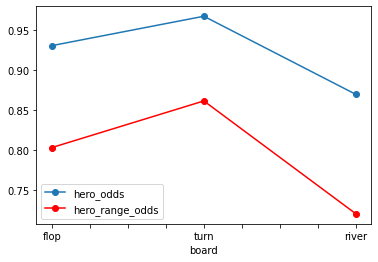

In [22]:
ax = plt.gca()
df_odds.plot(kind='line',x='board',y='hero_odds', marker='o', ax=ax)
df_odds.plot(kind='line',x='board',y='hero_range_odds',color='red' ,marker='o', ax=ax)
plt.show()

We observe that I was a major favorite of winning this heads-up hand even though the final result was not in my favor. That's why poker players say you should focus on the decisions you make not on the results you have.

Of course, all the analysis in this article assumed some ranges and basic poker strategies that formed my mental model at the time of playing and here implemented in Python. I'm no Poker Pro and there are many ways to go about this hand. I believe I have made several mistakes, for instance, underestimating the chances of the villain holding AJ given the pre-flop raise.

I would be very curious how others would have analyzed this hand using the Python framework utilized here. Feel free to go ahead and fork the [repo](https://github.com/souzatharsis/holdem_calc).